In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import timm
import numpy as np
from torchvision.datasets import ImageFolder
import os
from torchvision import transforms, models
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(123)

In [3]:
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299
BATCH_SIZE = 16

In [4]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [5]:
#================================Test data Evaluation===============================
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = test_loss / len(test_loader)

    accuracy = correct / total * 100.0

    return avg_loss, accuracy

In [6]:
#========================Training data========================
def train_model(model, train_loader, num_epochs, test_loader,filename):
    train_accuracy = []
    train_loss = []
    test_accuracy = []
    test_loss = []
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        model.eval()
        with torch.no_grad():
            ts_loss, ts_acc = evaluate_model(model, test_loader)
            # Check if current validation accuracy is the best
            if ts_acc > best_accuracy:
                best_accuracy = ts_acc
                print(f"Saving model at epoch {epoch+1} with validation accuracy: {ts_acc:.2f}%")
                save_checkpoint({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': ts_loss,
                    'accuracy': ts_acc
                }, filename)

        test_loss.append(ts_loss)
        test_accuracy.append(ts_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], accuracy: {(epoch_acc/100):.4f} loss: {epoch_loss:.4f}, | val_accuracy: {(ts_acc/100):.4f}, val_loss: {ts_loss:.4f}')

    return train_loss, train_accuracy, test_loss, test_accuracy

transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
class CustomImageFolder(ImageFolder):
    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and d.name != '.ipynb_checkpoints']
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [8]:
#========================Loading training dataset===========================
dataset = CustomImageFolder(root=r'data/training', transform=transform)
#================================Loading test dataset================================
val_dataset = CustomImageFolder(root=r'data/validation', transform=transform)

In [9]:
#==========================Creating batches based on the training dataset=====================
class_indices = [0, 1, 2]
train_dataset = torch.utils.data.Subset(dataset, [i for i in range(len(dataset)) if dataset.targets[i] in class_indices])
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
#==========================Creating batches based on the validation dataset=====================
val_dataset = torch.utils.data.Subset(val_dataset, [i for i in range(len(val_dataset)) if val_dataset.targets[i] in class_indices])
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Resnet50 Model

In [ ]:
model = models.resnet50(pretrained = True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#=================Training Resent50 model==================
train_loss, train_accuracy, val_loss, val_accuracy =  train_model(model, dataloader, 10, val_loader, r"models/resnet_50.pt")

Saving model at epoch 1 with validation accuracy: 82.83%
Epoch [1/10], accuracy: 0.5958 loss: 2.8167, | val_accuracy: 0.8283, val_loss: 0.8584
Saving model at epoch 2 with validation accuracy: 84.85%
Epoch [2/10], accuracy: 0.9104 loss: 0.4807, | val_accuracy: 0.8485, val_loss: 0.8106
Saving model at epoch 3 with validation accuracy: 91.92%
Epoch [3/10], accuracy: 0.9688 loss: 0.1320, | val_accuracy: 0.9192, val_loss: 0.3740
Epoch [4/10], accuracy: 0.9875 loss: 0.0432, | val_accuracy: 0.8889, val_loss: 0.4542
Epoch [5/10], accuracy: 0.9875 loss: 0.0340, | val_accuracy: 0.8586, val_loss: 0.5748
Epoch [6/10], accuracy: 0.9979 loss: 0.0133, | val_accuracy: 0.8485, val_loss: 0.4066
Epoch [7/10], accuracy: 0.9896 loss: 0.0469, | val_accuracy: 0.8990, val_loss: 0.3563
Epoch [8/10], accuracy: 0.9917 loss: 0.0260, | val_accuracy: 0.8889, val_loss: 0.3365
Epoch [9/10], accuracy: 0.9958 loss: 0.0144, | val_accuracy: 0.8687, val_loss: 0.5578
Epoch [10/10], accuracy: 0.9938 loss: 0.0161, | val_acc

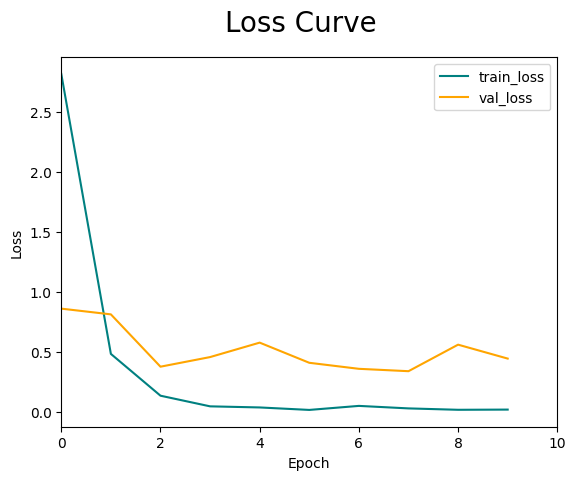

In [ ]:
#==========================Loss Function===========================
fig = plt.figure()
plt.plot(train_loss, color = 'teal', label = 'train_loss')
plt.plot(val_loss, color = 'orange', label = 'val_loss')
fig.suptitle('Loss Curve', fontsize = 20)
plt.legend(loc = 'upper right')
plt.xlim(0,10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

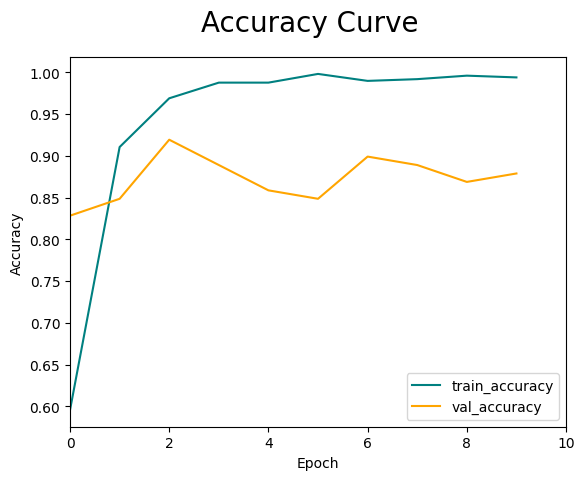

In [ ]:
#==========================Accuracy===========================
fig = plt.figure()
plt.plot(np.array(train_accuracy)/100, color = 'teal', label = 'train_accuracy')
plt.plot(np.array(val_accuracy)/100, color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy Curve', fontsize = 20)
plt.legend(loc = 'lower right')
plt.xlim(0,10)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [11]:
#===========================Evaluate the model based on the test dataset=====================
label_map = {'ChickenPox': 0, 'Measles': 1, 'MonkeyPox': 2}

def getType(id):
    return list(label_map.keys())[list(label_map.values()).index(id)]


def predict_images_class(model, val_data, image_width, image_height):
    val_df = pd.DataFrame(columns=['Image No.', 'Predicted Image Class'])
    cnn_img = [os.path.join(val_data, file) for file in os.listdir(val_data)[:]]

    for i, img_path in enumerate(cnn_img):
        image = Image.open(img_path).convert('RGB')
        image = transform(image)
        img = image.unsqueeze(0)
        with torch.no_grad():
            prediction = model(img)
        predicted_class_index = torch.argmax(prediction).item()
        predicted_class = getType(predicted_class_index)
        val_df.loc[len(val_df.index)] = [(i+1), predicted_class]

    return val_df

In [12]:
val_chicken_pox = os.path.join (r"data/test/ChickenPox")
val_measles = os.path.join (r"data/test/Measles")
val_monkey_pox = os.path.join (r"data/test/MonkeyPox")

## Prediction on New Images

In [17]:
model = models.resnet50(weights=None)

In [31]:
checkpoint = torch.load(r"models/resnet_50.pt", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
eval = model.eval()

In [32]:
chickenpox_val_df_cnn = predict_images_class(eval, val_chicken_pox, IMAGE_WIDTH, IMAGE_HEIGHT)
chickenpox_val_df_cnn["True Image Labels"] = "ChickenPox"
display(chickenpox_val_df_cnn)

,Image No.,Predicted Image Class,True Image Labels
0,1,ChickenPox,ChickenPox
1,2,Measles,ChickenPox
2,3,ChickenPox,ChickenPox
3,4,ChickenPox,ChickenPox
4,5,ChickenPox,ChickenPox
5,6,ChickenPox,ChickenPox
6,7,ChickenPox,ChickenPox
7,8,Measles,ChickenPox


In [33]:
measles_val_df_cnn = predict_images_class(eval, val_measles, IMAGE_WIDTH, IMAGE_HEIGHT)
measles_val_df_cnn["True Image Labels"] = "Measles"
display(measles_val_df_cnn)

,Image No.,Predicted Image Class,True Image Labels
0,1,Measles,Measles
1,2,Measles,Measles
2,3,Measles,Measles
3,4,Measles,Measles
4,5,ChickenPox,Measles
5,6,Measles,Measles
6,7,ChickenPox,Measles
7,8,ChickenPox,Measles


In [34]:
monkey_pox_df_cnn = predict_images_class(eval, val_monkey_pox, IMAGE_WIDTH, IMAGE_HEIGHT)
monkey_pox_df_cnn["True Image Labels"] = "MonkeyPox"
display(monkey_pox_df_cnn)

,Image No.,Predicted Image Class,True Image Labels
0,1,MonkeyPox,MonkeyPox
1,2,MonkeyPox,MonkeyPox
2,3,MonkeyPox,MonkeyPox
3,4,ChickenPox,MonkeyPox
4,5,Measles,MonkeyPox
5,6,ChickenPox,MonkeyPox
6,7,MonkeyPox,MonkeyPox
7,8,MonkeyPox,MonkeyPox


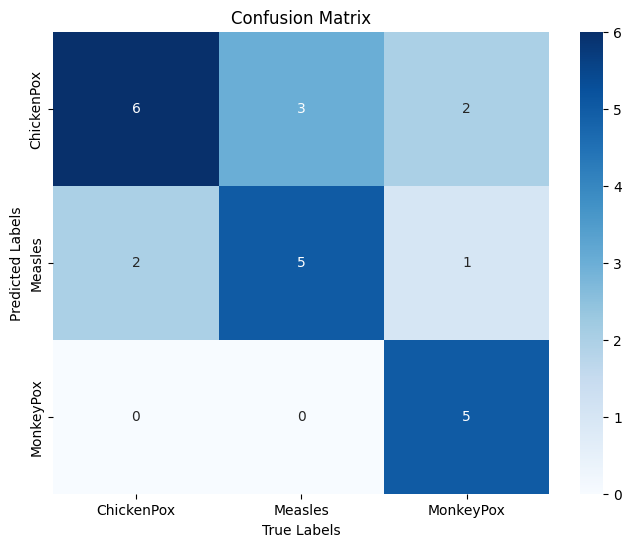

In [36]:
combined_df = pd.concat([chickenpox_val_df_cnn, measles_val_df_cnn, monkey_pox_df_cnn])

y_pred = combined_df['Predicted Image Class']
y_true = combined_df['True Image Labels']

cm = confusion_matrix(y_pred, y_true, labels=['ChickenPox', 'Measles', 'MonkeyPox'])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ChickenPox', 'Measles', 'MonkeyPox'], yticklabels=['ChickenPox', 'Measles', 'MonkeyPox'])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()

## NesNet-A-Large Model




In [13]:
model_se = timm.create_model('nasnetalarge', pretrained=True)
model_se = model_se.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_se.parameters(), lr=0.0001)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
#=================Training SE-ResNeXt-101 model==================
train_loss_se, train_accuracy_se, val_loss_se, val_accuracy_se =  train_model(model_se, dataloader, 10, val_loader, r"models/nasnetalarge.pt")

Saving model at epoch 1 with validation accuracy: 79.80%
Epoch [1/10], accuracy: 0.4354 loss: 3.4467, | val_accuracy: 0.7980, val_loss: 0.8050
Saving model at epoch 2 with validation accuracy: 83.84%
Epoch [2/10], accuracy: 0.9417 loss: 0.2071, | val_accuracy: 0.8384, val_loss: 0.6277
Saving model at epoch 3 with validation accuracy: 84.85%
Epoch [3/10], accuracy: 0.9667 loss: 0.1084, | val_accuracy: 0.8485, val_loss: 0.5178
Epoch [4/10], accuracy: 0.9938 loss: 0.0296, | val_accuracy: 0.8384, val_loss: 0.5558
Epoch [5/10], accuracy: 0.9896 loss: 0.0370, | val_accuracy: 0.8485, val_loss: 0.7834
Saving model at epoch 6 with validation accuracy: 85.86%
Epoch [6/10], accuracy: 0.9979 loss: 0.0139, | val_accuracy: 0.8586, val_loss: 0.6669
Epoch [7/10], accuracy: 0.9917 loss: 0.0233, | val_accuracy: 0.7980, val_loss: 0.8869
Epoch [8/10], accuracy: 0.9875 loss: 0.0237, | val_accuracy: 0.8081, val_loss: 0.8640
Epoch [9/10], accuracy: 0.9979 loss: 0.0117, | val_accuracy: 0.8182, val_loss: 0.730

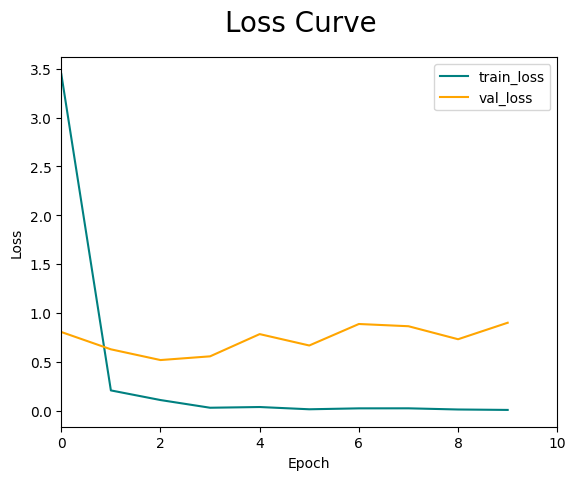

In [16]:
#==========================Loss Function===========================
fig = plt.figure()
plt.plot(train_loss_se, color = 'teal', label = 'train_loss')
plt.plot(val_loss_se, color = 'orange', label = 'val_loss')
fig.suptitle('Loss Curve', fontsize = 20)
plt.legend(loc = 'upper right')
plt.xlim(0,10)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

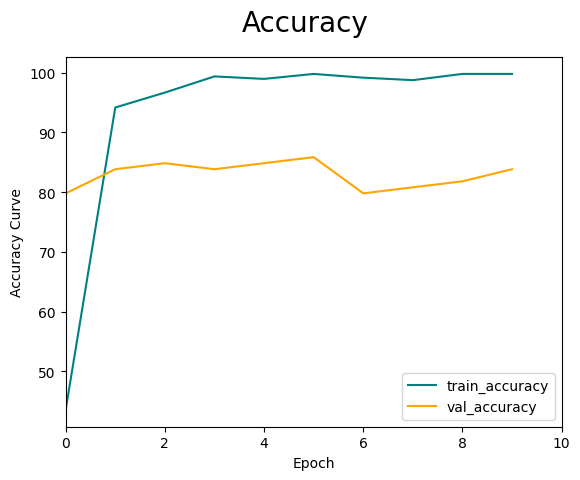

In [18]:
#==========================Accuracy===========================
fig = plt.figure()
plt.plot(train_accuracy_se, color = 'teal', label = 'train_accuracy')
plt.plot(val_accuracy_se, color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'lower right')
plt.xlim(0,10)
plt.xlabel('Epoch')
plt.ylabel('Accuracy Curve')
plt.show()

## Prediction on New Images

In [25]:
model = timm.create_model('nasnetalarge', pretrained=False)
checkpoint = torch.load(r"models/nasnetalarge.pt", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
eval = model.eval()

In [26]:
chickenpox_val_df_cnn = predict_images_class(eval, val_chicken_pox, IMAGE_WIDTH, IMAGE_HEIGHT)
chickenpox_val_df_cnn["True Image Labels"] = "ChickenPox"
display(chickenpox_val_df_cnn)

,Image No.,Predicted Image Class,True Image Labels
0,1,ChickenPox,ChickenPox
1,2,Measles,ChickenPox
2,3,ChickenPox,ChickenPox
3,4,ChickenPox,ChickenPox
4,5,ChickenPox,ChickenPox
5,6,ChickenPox,ChickenPox
6,7,ChickenPox,ChickenPox
7,8,Measles,ChickenPox


In [28]:
measles_val_df_cnn = predict_images_class(eval, val_measles, IMAGE_WIDTH, IMAGE_HEIGHT)
measles_val_df_cnn["True Image Labels"] = "Measles"
display(measles_val_df_cnn)

,Image No.,Predicted Image Class,True Image Labels
0,1,Measles,Measles
1,2,Measles,Measles
2,3,Measles,Measles
3,4,Measles,Measles
4,5,Measles,Measles
5,6,Measles,Measles
6,7,Measles,Measles
7,8,Measles,Measles


In [29]:
monkey_pox_df_cnn = predict_images_class(eval, val_monkey_pox, IMAGE_WIDTH, IMAGE_HEIGHT)
monkey_pox_df_cnn["True Image Labels"] = "MonkeyPox"
display(monkey_pox_df_cnn)

,Image No.,Predicted Image Class,True Image Labels
0,1,MonkeyPox,MonkeyPox
1,2,MonkeyPox,MonkeyPox
2,3,MonkeyPox,MonkeyPox
3,4,Measles,MonkeyPox
4,5,MonkeyPox,MonkeyPox
5,6,ChickenPox,MonkeyPox
6,7,MonkeyPox,MonkeyPox
7,8,MonkeyPox,MonkeyPox


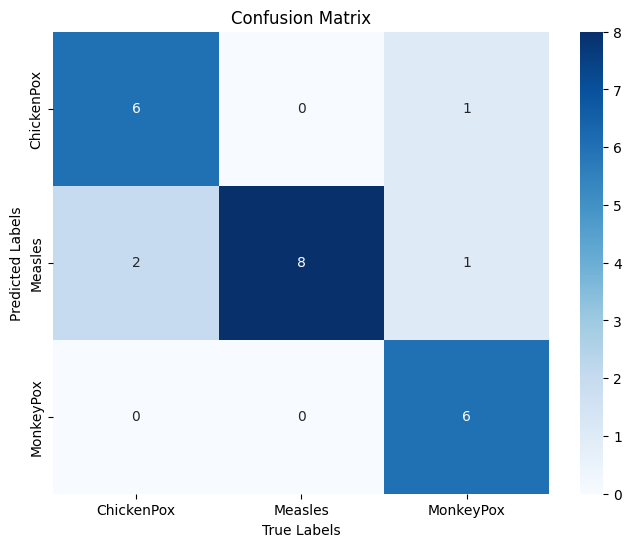

In [30]:
combined_df = pd.concat([chickenpox_val_df_cnn, measles_val_df_cnn, monkey_pox_df_cnn])

y_pred = combined_df['Predicted Image Class']
y_true = combined_df['True Image Labels']

cm = confusion_matrix(y_pred, y_true, labels=['ChickenPox', 'Measles', 'MonkeyPox'])

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ChickenPox', 'Measles', 'MonkeyPox'], yticklabels=['ChickenPox', 'Measles', 'MonkeyPox'])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()